# Finding the most visited datasets last month (by visit or API)

Last update : 15/12/2017

How to :

1. Run fetch_log.ipynb
2. Run aggregate_logs.ipynb
3. Run this notebook


In [1]:
import json
from collections import defaultdict, Counter
import pickle
import glob
import os
import itertools
from IPython.display import clear_output


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# import parser (regex on logs)
from src import utils

## Import deduplicated logs

In [2]:
# Compute monthly filename.json (e.g. : 2017-12-26)
a_month_ago = pd.datetime.today() + pd.DateOffset(months=-1)
date_range = pd.date_range(a_month_ago, pd.datetime.today()).strftime('%Y-%m-%d')
monthly_files = ['deduplicated_logs/' + file + '.json' for file in date_range]

unhandled_actions = []
visits_parsed = []
for filename in monthly_files:
    with open(filename, 'r') as f:
        visits = json.load(f)
    visits_parsed_file, unhandled_actions_file = utils.parse_visits(visits)
    visits_parsed += visits_parsed_file


## Keep only slug_or_id session

In [3]:
# Dict session_num -> list_of_action_tuple
visits_parsed_as_dict = dict(zip(range(0,len(visits_parsed)), visits_parsed))
visits_parsed_as_dict[2]

# Dict session_num -> set() of visited datasets (by API or through web)
session_datasets = {}
for key, value in visits_parsed_as_dict.items():
    if len(value) > 0:
        unique_list = set(tup[1] for tup in value if tup[0] == "slug_or_id")
        if len(unique_list) > 1 : # list of at least 2 different datasets
            session_datasets[key] = unique_list
    else:
        pass # We don't care about empty session
    

datasets_ref = pd.read_csv('./list_of_all_datasets_dgfr/datasets-2017-12-13-18-23.csv', sep=';')
# Mapping id -> slug
datasets_id_slug = datasets_ref.set_index('id')['slug'].to_dict()
# Replace all dataset_id by dataset_slug (caution: we keep the same dict name)
session_datasets = {key: [datasets_id_slug.get(el, el) for el in value] for key, value in session_datasets.items()}

In [4]:
all_datasets_as_list = []
for datasets in session_datasets.values():
    all_datasets_as_list += datasets

In [5]:
all_datasets_as_list = ['www.data.gouv.fr/datasets/' + ds for ds in all_datasets_as_list]

## top50 most visited datasets (through visits or API)

In [10]:
pd.set_option('display.max_colwidth', -1)
top50 = pd.DataFrame(Counter(all_datasets_as_list).most_common(50), columns=['dataset', 'last_month_visits'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115438940>]], dtype=object)

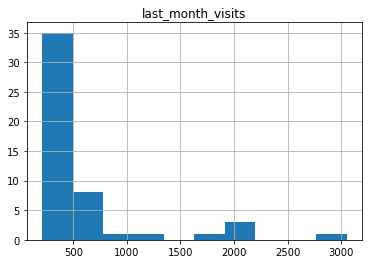

In [13]:
top50.hist()

In [8]:
top50.to_csv('./top50visited.csv', sep=';', index=False)